In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import mobilenet_v2
from torchvision.datasets import ImageFolder 
import torchvision 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

using device: cuda


In [3]:
#hyper params
batch_size = 64
num_epochs = 15
learning_rate = 0.0001
num_classes = len(os.listdir("FruitsDataset/train"))
print("num_classes:", num_classes)

num_classes: 36


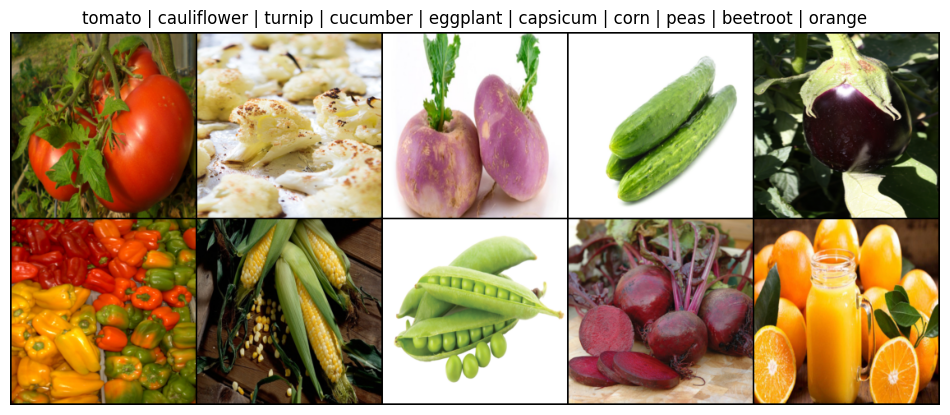

In [10]:

preview_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load preview dataset
preview_dataset = ImageFolder("FruitsDataset/train", transform=preview_transform)
prev_loader = DataLoader(preview_dataset, batch_size=10, shuffle=True)

# Get class names
class_names = preview_dataset.classes

# Grab one batch
images, labels = next(iter(prev_loader))

# Function to show a batch of images
def show_images(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # ✅ Corrected line
    plt.imshow(images)
    if title:
        plt.title(title)
    plt.axis('off')

# Plot the image grid
plt.figure(figsize=(12, 6))
show_images(
    torchvision.utils.make_grid(images, nrow=5),
    title=" | ".join([class_names[i] for i in labels])
)
plt.show()



In [15]:
main_dir = "FruitsDataset"
train_dir = os.path.join(main_dir,"train")
val_dir = os.path.join(main_dir,"validation")
test_dir = os.path.join(main_dir, "test")

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness = 0.2,
        contrast = 0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [16]:
train_data = ImageFolder(train_dir, transform = train_transform)
val_data = ImageFolder(val_dir, transform=test_transform)
test_data = ImageFolder(test_dir, transform=test_transform)

train_loader =DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 4, pin_memory= True, persistent_workers=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [17]:
model = models.mobilenet_v2(pretrained = True)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2),
    nn.Linear(model.last_channel, num_classes)
)

model = model.to(device)

c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jomar\VSCode\ML\BasicML\ML\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Jomar/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:12<00:00, 1.15MB/s]


In [18]:
criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = optim.Adam(
    model.parameters(),
    lr = learning_rate
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience = 2,
    factor = 0.5
)

In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    loss = 0.0
    correct, total = 0,0
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct/total
    print("Epoch {}: Train Loss: {.4f}, Acc: {:.4f}".format(
        num_epochs + 1, loss, train_acc
    ))